## Real-Time Weather Intelligence System for Tourism Operations and Strategy

#### Contributors:  
*Joanna Marie Corpuz — 131120*  
*Thi Minh Ngoc Dao — 131112*  
*Li Xinyi — 131082*

#### Project Overview

This project delivers a **Real-Time Weather Intelligence System** to support both *operational decisions* and *strategic planning* in the tourism sector.  
It enables travel agencies, tour operators, and hospitality teams to:

- Monitor live weather across 30+ global cities
- Trigger real-time alerts for discomfort or risk
- Recommend activities based on current suitability
- Analyze long-term weather patterns for smarter planning and promotions

The system integrates real-time streaming (Kafka + Spark) with interactive dashboards and historical analytics — bridging reactive decision-making with proactive insight.

---

#### Project Goals

- Stream live weather from multiple cities using Kafka and Spark
- Apply sliding/tumbling windows to simulate real-time conditions
- Generate live alerts for heat, wind, or storm risks
- Recommend weather-appropriate activities in near real time
- Visualize and compare city-level weather trends interactively
- *Use historical data to uncover patterns and improve forecast readiness*
- *Support weather-driven marketing and travel product strategy*

---

#### Technical Stack

<table style="margin-left: 0; margin-right: auto; text-align: left;">
  <thead>
    <tr>
      <th>Component</th>
      <th>Technology</th>
    </tr>
  </thead>
  <tbody>
    <tr><td>Data Source</td><td>OpenWeatherMap API (via Kafka producer)</td></tr>
    <tr><td>Streaming Engine</td><td>Spark Structured Streaming</td></tr>
    <tr><td>Storage Format</td><td><code>.parquet</code></td></tr>
    <tr><td>Data Handling</td><td>Pandas</td></tr>
    <tr><td>Visualization</td><td>Plotly, Folium, Matplotlib, Seaborn</td></tr>
    <tr><td>Interface</td><td>Jupyter Notebook</td></tr>
  </tbody>
</table>  

  
---

#### System Features & Visual Components

- **Live Map Dashboard** — real-time Folium map with weather markers  
- **Streaming Alerts** — identify safety risks (e.g., heat, storms) with action tags  
- **Activity Suitability Scoring** — recommend travel activities based on current conditions  
- **Radar & Time Series Charts** — summarize weather quality and stability  
- **Travel Suitability Heatmaps** — identify best hours for outdoor experiences  
- **Volatility & Predictability Metrics** — support planning and risk analysis  
- **Marketing Intelligence Dashboard** — align promotions with weather trends

> *Real-time components operate across 30+ cities; historical analysis uses a focused subset for strategic depth.*  
> *The system is modular and ready for future integration into traveler apps or live alert systems.*

> ℹ️ **Note **  
The dashboards and visualizations in this project are displayed as static snapshots within a Jupyter notebook. While they reflect real-time data and logic, they are not set up for continuous auto-refresh. Tools like Streamlit or Dash could be added in the future to enable fully interactive, live-updating dashboards. For this phase, the focus was on building and validating the real-time data pipeline and core analytics features.

---

### Step 1: Check Required Packages

In [56]:
import importlib

required = [
    ("kafka", "kafka-python"),
    ("requests", "requests"),
    ("pyspark", "pyspark"),
    ("matplotlib", "matplotlib"),
    ("seaborn", "seaborn"),
    ("folium", "folium"),
    ("pandas", "pandas")
]


missing = []

for module_name, package_name in required:
    try:
        importlib.import_module(module_name)
        print(f" {package_name} is already installed.")
    except ImportError:
        print(f" {package_name} is missing.")
        missing.append(package_name)

missing_packages = " ".join(missing)

 kafka-python is already installed.
 requests is already installed.
 pyspark is already installed.
 matplotlib is already installed.
 seaborn is already installed.
 folium is already installed.
 pandas is already installed.


### Step 2: Install Missing Packages (if applicable)

In [2]:
import sys, subprocess

if 'missing_packages' in globals() and missing_packages:
    print(f" Installing: {missing_packages}")
    subprocess.check_call([sys.executable, "-m", "pip", "install"] + missing_packages.split())
else:
    print(" All required packages are already installed.")

 All required packages are already installed.


### Step 3: Start Kafka with Docker Compose

We use Docker Compose to spin up the necessary services for Apache Kafka, including ZooKeeper and the Kafka broker.

> 📦 Docker must be running before starting this step.

In [3]:
# Start Kafka and Zookeeper containers in the background
!docker-compose up -d

WARN[0000] /mnt/c/Users/joann/Documents/kafka-weather-streaming/docker-compose.yml: the attribute `version` is obsolete, it will be ignored, please remove it to avoid potential confusion 
[+] Running 2/2
 ✔ Container kafka-weather-streaming-zookeeper-1  Running                  0.0s 
 ✔ Container kafka-weather-streaming-kafka-1      Running                  0.0s 


In [3]:
# Check status of running containers
!docker ps

CONTAINER ID   IMAGE                             COMMAND                  CREATED       STATUS         PORTS                                        NAMES
cab2cef78b1c   confluentinc/cp-kafka:7.3.0       "/etc/confluent/dock…"   10 days ago   Up 5 minutes   0.0.0.0:9092->9092/tcp                       kafka-weather-streaming-kafka-1
e749fdf681fd   confluentinc/cp-zookeeper:7.3.0   "/etc/confluent/dock…"   10 days ago   Up 5 minutes   2888/tcp, 0.0.0.0:2181->2181/tcp, 3888/tcp   kafka-weather-streaming-zookeeper-1


### Step 4: Create Kafka Topic for Weather Streaming

Kafka topics are the channels where data is written and read from. We'll create a topic called `weather-stream` to hold real-time weather updates from different cities.

> ⚠️ This step must be run after Kafka and Zookeeper are running.

We'll use the built-in Kafka topic creation command by **executing it inside the Kafka container**.

- `--bootstrap-server`: the address of our Kafka broker (usually `localhost:9092`)
- `--replication-factor`: set to 1 (for single-node dev use)
- `--partitions`: set to 1 (we may scale later)

In [6]:
# Create Kafka topic using correct path for confluentinc/cp-kafka
!docker exec kafka-weather-streaming-kafka-1 \
  /usr/bin/kafka-topics --create \
  --topic weather-stream \
  --bootstrap-server localhost:9092 \
  --replication-factor 1 \
  --partitions 1

Error while executing topic command : Topic 'weather-stream' already exists.
[2025-05-31 12:35:02,091] ERROR org.apache.kafka.common.errors.TopicExistsException: Topic 'weather-stream' already exists.
 (kafka.admin.TopicCommand$)


In [4]:
# Check if kafka topic was created

!docker exec kafka-weather-streaming-kafka-1 \
  /usr/bin/kafka-topics --list \
  --bootstrap-server localhost:9092

weather-stream


### Step 5: Python Kafka Producer for OpenWeatherMap API

We now write a Python script that will:

1. Call the OpenWeatherMap API to fetch current weather data for selected cities
2. Format the response as JSON
3. Publish each result to the Kafka topic `weather-stream`

This runs in a loop, continuously producing fresh weather messages for processing.

#### 🛠️ Requirements
- An active OpenWeatherMap API key
- The Python libraries:
  - `requests` for HTTP calls
  - `kafka-python` for sending messages to Kafka

We'll test this with a few sample cities (e.g., Warsaw, London, Madrid, Berlin).

> ⚠️ **Your API key is required** for this step. If an API key is not available, one can be obtained from: https://openweathermap.org/api

In [5]:
%%writefile producer.py
# producer.py

import json, time, requests
from kafka import KafkaProducer

API_KEY = "0e4055bdf6c6b9529514d47772c1cf24" # replace this with your API key
CITIES = [
    'New York', 'Los Angeles', 'Rio de Janeiro', 'San Francisco',
    'Mexico City', 'Toronto', 'London', 'Paris', 'Rome', 'Barcelona',
    'Krakow', 'Tokyo', 'Seoul', 'Singapore', 'Hanoi', 'Puerto Princesa',
    'Beijing', 'Delhi', 'Dubai', 'Istanbul', 'Cairo', 'Nairobi',
    'Cape Town', 'Sydney', 'Auckland', 'Warsaw', 'Bali',
    'Malé', 'Moscow', 'Oslo'
]

KAFKA_TOPIC = "weather-stream"
KAFKA_BOOTSTRAP_SERVERS = "localhost:9092"

producer = KafkaProducer(
    bootstrap_servers=KAFKA_BOOTSTRAP_SERVERS,
    value_serializer=lambda v: json.dumps(v).encode("utf-8")
)

def fetch_weather(city):
    url = (
        f"http://api.openweathermap.org/data/2.5/weather?"
        f"q={city}&appid={API_KEY}&units=metric"
    )
    response = requests.get(url)
    if response.status_code == 200:
        return response.json()

def stream_weather():
    while True:
        for city in CITIES:
            data = fetch_weather(city)
            if data:
                print(f"[SENT] {city} →", json.dumps(data))
                producer.send(KAFKA_TOPIC, value=data)
            time.sleep(10)  

if __name__ == "__main__":
    stream_weather()

Writing producer.py


---
Now that the `producer.py` script is ready, we can run it to begin streaming real-time weather data into Kafka.

This script will:

- Pull live weather data for 30 cities
- Send each city's data every 10 seconds to the Kafka topic `weather-stream`

> ⚠️ Ensure Kafka and Zookeeper are running before starting the producer.

**Run the Producer (Terminal or PowerShell)**

Navigate to your project directory and run:

```bash
python producer.py

### Step 6: Consume Weather Stream with PySpark Structured Streaming

Now that weather data is being published to the `weather-stream` Kafka topic, we use PySpark to read, parse, and structure the stream in real time.

This step includes:
1. Initializing SparkSession with the required Kafka package.
2. Reading from Kafka using `spark.readStream`, subscribing to the `weather-stream` topic.
3. Parsing JSON payloads using a predefined schema that matches the structure of OpenWeatherMap API responses.
4. Extracting structured fields, including:
   - `name` → city  
   - `coord.lat`, `coord.lon` → coordinates  
   - `main.temp`, `feels_like`, `humidity` → core weather metrics  
   - `weather[0].main`, `weather[0].description` → condition summaries  
   - `wind.speed`, `visibility`, `clouds.all`, `sys.country`  
   - `dt` → UNIX timestamp, converted to readable datetime
5. Writing to multiple outputs:
   - `.parquet` files to `/tmp/stream_weather_output/` for downstream analytics
   - Console output for live debugging and verification

Two separate streams are started from the same transformed DataFrame — one for file storage and one for console monitoring. This allows both real-time inspection and long-term retention of weather data.

In [6]:
%%writefile consumer.py
from pyspark.sql import SparkSession
from pyspark.sql.functions import from_json, col, from_unixtime
from pyspark.sql.types import StructType, StructField, StringType, DoubleType, IntegerType, ArrayType

# Create Spark session
spark = SparkSession.builder.appName("WeatherStreamingApp") \
    .config("spark.jars.packages", "org.apache.spark:spark-sql-kafka-0-10_2.12:3.5.0") \
    .getOrCreate()

spark.sparkContext.setLogLevel("WARN")

# Define schema
weather_schema = StructType([
    StructField("name", StringType()),
    StructField("dt", IntegerType()),
    StructField("visibility", IntegerType()),
    StructField("coord", StructType([
        StructField("lat", DoubleType()),
        StructField("lon", DoubleType())
    ])),
    StructField("main", StructType([
        StructField("temp", DoubleType()),
        StructField("feels_like", DoubleType()),
        StructField("humidity", IntegerType())
    ])),
    StructField("wind", StructType([
        StructField("speed", DoubleType())
    ])),
    StructField("weather", ArrayType(
        StructType([
            StructField("main", StringType()),
            StructField("description", StringType())
        ])
    )),
    StructField("sys", StructType([
        StructField("country", StringType())
    ])),
    StructField("clouds", StructType([
        StructField("all", IntegerType())
    ]))
])

# Read from Kafka
raw_df = spark.readStream \
    .format("kafka") \
    .option("kafka.bootstrap.servers", "localhost:9092") \
    .option("subscribe", "weather-stream") \
    .option("startingOffsets", "latest") \
    .option("failOnDataLoss", "false") \
    .load()

# Parse JSON
json_df = raw_df.selectExpr("CAST(value AS STRING)")
parsed_df = json_df.select(from_json(col("value"), weather_schema).alias("data"))

# Extract fields
weather_df = parsed_df.select(
    col("data.name").alias("city"),
    col("data.coord.lat").alias("latitude"),
    col("data.coord.lon").alias("longitude"),
    col("data.main.temp").alias("temperature"),
    col("data.main.feels_like").alias("feels_like"),
    col("data.main.humidity").alias("humidity"),
    col("data.wind.speed").alias("wind_speed"),
    col("data.visibility").alias("visibility"),
    col("data.weather")[0]["main"].alias("condition_main"),
    col("data.weather")[0]["description"].alias("condition_desc"),
    col("data.sys.country").alias("country"),
    col("data.clouds.all").alias("cloudiness"),
    col("data.dt").alias("timestamp"),
    from_unixtime(col("data.dt")).alias("timestamp_readable")
)

spark.sparkContext.setLogLevel("ERROR")

# One stream to write to file (for Databricks later)
weather_df.writeStream \
    .format("parquet") \
    .option("path", "/tmp/stream_weather_output/") \
    .option("checkpointLocation", "/tmp/stream_weather_checkpoint/") \
    .outputMode("append") \
    .start()

# Another stream to print to console (for live debug view)
weather_df.writeStream \
    .format("console") \
    .option("truncate", "false") \
    .outputMode("append") \
    .start() \
    .awaitTermination()

Writing consumer.py


**Run the consumer (Terminal or PowerShell)**

Navigate to your project directory and run:

```bash
spark-submit \
  --packages org.apache.spark:spark-sql-kafka-0-10_2.12:3.5.0 \
  consumer.py

In [9]:
import os

output_path = "/tmp/stream_weather_checkpoint/"
if os.path.exists(output_path):
    print("Found directory. Files inside:")
    print(os.listdir(output_path))
else:
    print("CSV output folder not found.")

Found directory. Files inside:
['commits', '.metadata.crc', 'sources', 'offsets', 'metadata']


  
### Step 7: Build and Interpret the Real-Time Dashboard

With the weather data now streaming and stored using Spark, this step focuses on building and interpreting key sections of the dashboard using Pandas, Plotly, and Folium.

This next block reads previously streamed weather data from local `.parquet` files into a Spark DataFrame for analysis. It registers the data as a temporary SQL view (`weather`) and displays a sample of the records for inspection.

In [11]:
from pyspark.sql import SparkSession

spark = SparkSession.builder.appName("ReadWeatherData").getOrCreate()

df = spark.read.parquet("/tmp/stream_weather_output/")
df.createOrReplaceTempView("weather")
df.show(8, truncate=False)

+------+--------+---------+-----------+----------+--------+----------+----------+--------------+--------------+-------+----------+----------+-------------------+
|city  |latitude|longitude|temperature|feels_like|humidity|wind_speed|visibility|condition_main|condition_desc|country|cloudiness|timestamp |timestamp_readable |
+------+--------+---------+-----------+----------+--------+----------+----------+--------------+--------------+-------+----------+----------+-------------------+
|London|51.5085 |-0.1257  |14.43      |13.44     |58      |2.68      |10000     |Clouds        |few clouds    |GB     |12        |1748901669|2025-06-03 00:01:09|
|Rome  |34.257  |-85.1647 |28.72      |29.77     |54      |2.06      |10000     |Clouds        |few clouds    |US     |20        |1748902264|2025-06-03 00:11:04|
|Paris |48.8534 |2.3488   |15.22      |14.52     |66      |2.06      |10000     |Clear         |clear sky     |FR     |0         |1748902174|2025-06-03 00:09:34|
+------+--------+---------+-

In [12]:
# Convert to pandas
pandas_df = df.toPandas()
pandas_df.head()

,city,latitude,longitude,temperature,feels_like,humidity,wind_speed,visibility,condition_main,condition_desc,country,cloudiness,timestamp,timestamp_readable
0,London,51.5085,-0.1257,14.43,13.44,58,2.68,10000,Clouds,few clouds,GB,12,1748901669,2025-06-03 00:01:09
1,Rome,34.2570,-85.1647,28.72,29.77,54,2.06,10000,Clouds,few clouds,US,20,1748902264,2025-06-03 00:11:04
2,Paris,48.8534,2.3488,15.22,14.52,66,2.06,10000,Clear,clear sky,FR,0,1748902174,2025-06-03 00:09:34


### Dashboard 1: Live Weather Map

The Live Weather Map presents the most recent weather conditions across selected cities using a Folium-based map. Each city is represented by a circular marker with a popup that displays details including temperature, wind speed, humidity, weather condition, and timestamp.

The visualization reflects a *fixed 15-minute tumbling window*, showing the most recent weather reading per city *within the last completed 15-minute interval*. This provides a consistent, time-aligned snapshot that supports clear comparisons across locations and avoids overlap with incoming partial data.

##### Color-coding logic:

🔴 **Red**: Assigned to cities experiencing "Rain", "Thunderstorm", or "Snow" — indicating high-risk or disruptive weather  
🟡 **Amber**: Assigned to cities under "Clouds" or "Mist" — representing moderate or uncertain conditions  
🟢 **Green**: Assigned to all other conditions — indicating generally clear or favorable weather

In [49]:
%%writefile live_weather_map.py
import streamlit as st
import pandas as pd
import folium
from folium.plugins import MarkerCluster
from streamlit_folium import st_folium
from pyspark.sql import SparkSession
from datetime import timedelta

# App title
st.set_page_config(page_title="Live Weather Map", layout="wide")
st.title("🌍 Live Weather Map (Real-Time)")

# Load data from parquet via Spark
@st.cache_resource(ttl=60)  # refresh every 60s
def load_latest_weather():
    spark = SparkSession.builder.appName("ReadWeatherData").getOrCreate()
    df = spark.read.parquet("/tmp/stream_weather_output/")
    pdf = df.toPandas()

    # Convert timestamp to datetime
    pdf['timestamp_readable'] = pd.to_datetime(pdf['timestamp_readable'])

    # Align to latest 15-minute window
    now = pdf['timestamp_readable'].max()
    aligned_now = now - timedelta(
        minutes=now.minute % 15,
        seconds=now.second,
        microseconds=now.microsecond
    )
    window_start = aligned_now - timedelta(minutes=15)

    # Filter for window & dedupe per city
    window_df = pdf[(pdf['timestamp_readable'] >= window_start) & (pdf['timestamp_readable'] <= aligned_now)].copy()
    latest_df = window_df.sort_values("timestamp_readable", ascending=False).drop_duplicates("city")

    return latest_df

# Load data
df = load_latest_weather()

if df.empty:
    st.warning("⚠️ No weather data available in the last 15 minutes.")
    st.stop()

# Build folium map
m = folium.Map(location=[20, 0], zoom_start=2)
marker_cluster = MarkerCluster().add_to(m)

for _, row in df.iterrows():
    popup_text = (
        f"<b>{row['city']}, {row['country']}</b><br>"
        f"Temp: {row['temperature']}°C<br>"
        f"Feels Like: {row['feels_like']}°C<br>"
        f"Weather: {row['condition_desc']}<br>"
        f"Humidity: {row['humidity']}%<br>"
        f"Wind: {row['wind_speed']} m/s<br>"
        f"Time: {row['timestamp_readable']}"
    )

    # Color by condition
    condition = row['condition_main']
    if condition in ["Rain", "Thunderstorm", "Snow"]:
        colour = "red"
    elif condition in ["Clouds", "Mist"]:
        colour = "orange"
    else:
        colour = "green"

    folium.CircleMarker(
        location=[row["latitude"], row["longitude"]],
        radius=6,
        color=colour,
        fill=True,
        fill_color=colour,
        fill_opacity=0.7,
        popup=folium.Popup(popup_text, max_width=250)
    ).add_to(marker_cluster)

# Display map
st_folium(m, width=900, height=600)

st.caption("🕒 Map updates automatically every 60 seconds with the most recent data.")

Writing live_weather_map.py


**Run the live_weather_map (Terminal or PowerShell)**

Navigate to your project directory and run:

```bash
streamlit run live_weather_map.py

This visualization provides centralized, real-time monitoring of weather conditions across multiple tourist destinations. It enables operators and agencies to oversee activities and respond to changing conditions, even without being physically present. The color-coded markers support fast, coordinated decisions across teams.

**How This Can Be Used**
- *For Travel Agencies*: To determine which destinations to recommend or deprioritize based on live conditions.
- *For Tour Operators*: To make real-time adjustments to schedules and ensure client safety across multiple cities.
- *For Hospitality Teams*: To provide timely, personalized activity suggestions to guests.
- *For Marketing Teams*: To dynamically tailor promotions or messaging based on weather-driven destination appeal.

The dashboard bridges weather intelligence with spatial business actions — offering consistent, objective insights across all active locations.  
Its color-coded map enables operators, even those not physically present, to quickly assess weather severity across cities, prioritize responses, and coordinate with local teams or guides.

**Sample insights from the result:**
1. Several locations in *East and Southeast Asia* (e.g., Seoul, Tokyo, Hanoi) are showing *amber markers*, indicating moderate conditions such as "Clouds" or "Mist". This may signal overcast or transitional weather that could affect scenic views, photography tours, or open-air markets.
   - *Tour operators* may choose to re-sequence the day’s itinerary — for example, scheduling indoor activities or cultural experiences earlier in the day while postponing sightseeing to later hours if weather improves.
   - *Marketing and guest services teams* might also adjust promotions, highlighting indoor excursions like museums, food tours, or spa packages that are more resilient to uncertain weather.
2. *Green markers* dominate parts of *India, the Middle East, and East Africa*, indicating clear, favorable conditions. These areas present opportunities to promote outdoor tours, walking routes, and time-sensitive experiences like sunset cruises or open-air markets.
   - *Travel agencies* could prioritize these locations in near-term travel recommendations or boost real-time offers through email and in-app messaging.
   - *Tour guides on the ground* may extend or add optional excursions for guests while conditions remain optimal.

---

### Dashboard 2: Activity Recommendations Based on Weather Suitability

This section helps tourism operators and concierge teams answer a practical question:  
*Which destinations are currently best suited for popular travel activities based on the latest weather conditions?*

We evaluate live weather data to recommend cities for three categories of experience:

- **🏞️ Outdoor Exploration** — hiking, walking tours, parks
- **🏙️ City Leisure** — sightseeing, open-air cafes, casual strolls
- **🏖️ Beach & Water Relaxation** — lounging, light swimming, beachfront dining  


**Scoring Strategy**

To keep scores relevant and responsive, we use a *30-minute sliding window*, updated with the latest streamed weather data.  
Key weather fields like temperature, humidity, visibility, and condition are used to score each city’s suitability for each activity.

Only cities that meet basic applicability filters (e.g., coastal cities for beach scores) are considered per category.


<h4>Scoring Criteria (Simplified Summary)</h4>

<table style="margin-left: 0; margin-right: auto; text-align: left;">
  <thead>
    <tr>
      <th>Weather Attribute</th>
      <th>Outdoor Exploration</th>
      <th>City Leisure</th>
      <th>Beach &amp; Water Relaxation</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td><code>temperature</code></td>
      <td>Ideal: 17–24°C → +0.5</td>
      <td>Ideal: 18–28°C → +0.4</td>
      <td>Ideal: 27–32°C → +0.5</td>
    </tr>
    <tr>
      <td><code>humidity</code></td>
      <td>&lt;60% → +0.1</td>
      <td>Not used</td>
      <td>Not used</td>
    </tr>
    <tr>
      <td><code>wind_speed</code></td>
      <td>&lt;5 m/s → +0.15</td>
      <td>Not used</td>
      <td>&lt;4.5 m/s → +0.2</td>
    </tr>
    <tr>
      <td><code>visibility</code></td>
      <td>Not used</td>
      <td>&gt;8000 m → +0.3</td>
      <td>Not used</td>
    </tr>
    <tr>
      <td><code>condition_main</code></td>
      <td>"Clear" or "Clouds" → +0.25, else = 0</td>
      <td>"Clear" or "Clouds" → +0.3</td>
      <td>"Clear" → +0.3, Rain/Storm caps score ≤ 0.2</td>
    </tr>
    <tr>
      <td><strong>City Filter</strong></td>
      <td>All cities except Malé, Bali</td>
      <td>All cities</td>
      <td>Only coastal cities (e.g., Barcelona, Rio)</td>
    </tr>
  </tbody>
</table>



**How Scores Are Used**

- Scores are additive, capped if weather is severe
- Final values are scaled to *0–100%*
- The dashboard highlights *only the top city (or tied cities)* per activity

*Note:*  
Beach suitability is only scored for selected coastal cities:  
*Rio de Janeiro, San Francisco, Barcelona, Puerto Princesa, Dubai, Cape Town, Sydney, Bali, Malé*

In [47]:
%%writefile activity_recommendations.py
import streamlit as st
import seaborn as sns
import pandas as pd
from datetime import timedelta
from datetime import datetime
from pyspark.sql import SparkSession
import altair as alt
import matplotlib.pyplot as plt

st.set_page_config(page_title="Dashboard 2", layout="wide")
st.title("🌍 Dashboard 2: Activity Recommendations Based on Real-Time Weather")
now = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
st.markdown(f"🕒 **Current Time:** {now}")

@st.cache_resource(ttl=60)
def load_data():
    spark = SparkSession.builder.appName("WeatherScore").getOrCreate()
    df = spark.read.parquet("/tmp/stream_weather_output/")
    return df.toPandas()

pandas_df = load_data()
if pandas_df.empty:
    st.warning("No weather data available.")
    st.stop()

pandas_df['timestamp_readable'] = pd.to_datetime(pandas_df['timestamp_readable'])

now = pandas_df['timestamp_readable'].max()
aligned_now = now - timedelta(
    minutes=now.minute % 5,
    seconds=now.second,
    microseconds=now.microsecond
)
window_start = aligned_now - timedelta(minutes=30)

window_df = pandas_df[
    (pandas_df['timestamp_readable'] >= window_start) &
    (pandas_df['timestamp_readable'] < aligned_now)
].copy()

agg_df = window_df.sort_values("timestamp_readable").groupby("city").agg({
    'temperature': 'mean',
    'humidity': 'mean',
    'wind_speed': 'max',
    'visibility': 'mean',
    'condition_main': 'last',
    'cloudiness': 'mean',
    'latitude': 'last',
    'longitude': 'last',
    'country': 'last',
    'timestamp_readable': 'last'
}).reset_index()

beach_cities = ["Rio de Janeiro", "San Francisco", "Barcelona", "Puerto Princesa",
                "Dubai", "Cape Town", "Sydney", "Bali", "Mal\u00e9"]
excluded_exploration = ["Mal\u00e9", "Bali"]

def score_outdoor_exploration(row):
    if row["city"] in excluded_exploration or row["condition_main"] in ["Rain", "Thunderstorm", "Snow"]:
        return 0.0
    return round(
        (0.5 if 17 <= row["temperature"] <= 24 else 0) +
        (0.1 if row["humidity"] < 60 else 0) +
        (0.15 if row["wind_speed"] <= 5 else 0) +
        (0.25 if row["condition_main"] in ["Clear", "Clouds"] else 0), 3)

def score_city_leisure(row):
    return round(
        (0.4 if 18 <= row["temperature"] <= 28 else 0) +
        (0.3 if row["visibility"] > 8000 else 0) +
        (0.3 if row["condition_main"] in ["Clear", "Clouds"] else 0), 3)

def score_beach_relaxation(row):
    if row["city"] not in beach_cities:
        return None
    score = (
        (0.5 if 27 <= row["temperature"] <= 32 else 0) +
        (0.2 if row["wind_speed"] < 4.5 else 0) +
        (0.3 if row["condition_main"] == "Clear" else 0)
    )
    if row["condition_main"] in ["Rain", "Thunderstorm"]:
        return min(score, 0.2)
    return round(score, 3)

agg_df["outdoor_score"] = agg_df.apply(score_outdoor_exploration, axis=1)
agg_df["leisure_score"] = agg_df.apply(score_city_leisure, axis=1)
agg_df["beach_score"] = agg_df.apply(score_beach_relaxation, axis=1)

def top_percent(df, col):
    top_scores = df[col].dropna().drop_duplicates().nlargest(1).tolist()
    top_df = df[df[col].isin(top_scores)].copy()
    top_df[col + "_percent"] = (top_df[col] * 100).astype(int).astype(str) + "%"
    return top_df[["city", "temperature", "humidity", "wind_speed", col + "_percent"]] \
             .rename(columns={col + "_percent": "score"}) \
             .sort_values("score", ascending=False).reset_index(drop=True)

outdoor_display = top_percent(agg_df, "outdoor_score")
leisure_display = top_percent(agg_df, "leisure_score")
beach_display = top_percent(agg_df, "beach_score")

col1, col2, col3 = st.columns(3)
with col1:
    st.markdown("### 🥾 1. Outdoor Exploration")
    st.markdown("*hiking, walking tours, parks*", unsafe_allow_html=True)
    st.dataframe(outdoor_display, use_container_width=True)

with col2:
    st.markdown("### 🏙️ 2. City Leisure")
    st.markdown("*sightseeing, open-air cafes, casual strolls*", unsafe_allow_html=True)
    st.dataframe(leisure_display, use_container_width=True)

with col3:
    st.markdown("### 🏖️ Beach & Water Relaxation")
    st.markdown("*lounging, light swimming, beachfront dining*", unsafe_allow_html=True)
    st.dataframe(beach_display, use_container_width=True)

st.caption("\U0001F4C5 Updated every 60 seconds with the latest weather streaming data.")

# --- Temperature Trends Across Selected Cities ---
st.markdown("## 🌡️ Temperature Trends Across Selected Cities")

# Multiselect city picker
selected_cities = st.multiselect(
    "Compare temperature trends across cities:",
    pandas_df["city"].unique(),
    default=pandas_df["city"].unique()[:3]
)

# Filter dataframe for selected cities
filtered_df = pandas_df[pandas_df["city"].isin(selected_cities)].sort_values("timestamp_readable")

if not filtered_df.empty:
    # --- Line chart: Temperature over time ---
    temp_trend_chart = alt.Chart(filtered_df).mark_line().encode(
        x=alt.X("timestamp_readable:T", title="Time"),
        y=alt.Y("temperature:Q", title="Temperature (°C)"),
        color="city:N",
        tooltip=["city", "timestamp_readable", "temperature"]
    ).properties(title="Temperature Comparison", height=300)

    st.altair_chart(temp_trend_chart, use_container_width=True)

    # --- Two charts side by side ---
    col1, col2 = st.columns(2)

    # --- Bar chart: temperature comparison ---
    with col1:
        st.markdown("### Temperature Across Selected Cities")
        fig1, ax1 = plt.subplots()
        sns.barplot(data=filtered_df, x="city", y="temperature", ax=ax1)
        ax1.set_ylabel("Temperature (°C)", fontsize=11)
        ax1.set_xlabel("")
        ax1.set_title("Temperature by City", fontsize=13)
        ax1.tick_params(axis='x', labelsize=10)
        st.pyplot(fig1)

    # --- Scatter plot: wind vs humidity ---
    with col2:
        st.markdown("### Wind Speed vs Humidity")
        fig2, ax2 = plt.subplots()
        # Loop over cities to plot each with different color and label
        for city in filtered_df["city"].unique():
            city_data = filtered_df[filtered_df["city"] == city]
            ax2.scatter(
                city_data["wind_speed"], 
                city_data["humidity"], 
                label=city,
                alpha=0.7,
                s=60  # marker size
            )

        ax2.set_xlabel("Wind Speed (m/s)", fontsize=11)
        ax2.set_ylabel("Humidity (%)", fontsize=11)
        ax2.set_title("Wind vs Humidity by City", fontsize=13)
        ax2.tick_params(labelsize=10)
        ax2.legend(title="City", fontsize=8, title_fontsize=9, loc="upper right")
        st.pyplot(fig2)

else:
    st.warning("Please select at least one city with available data.")

# City selection for detailed climate trend
latest_city = st.selectbox("View detailed weather log for a city:", pandas_df["city"].unique())
city_data = pandas_df[pandas_df["city"] == latest_city].sort_values("timestamp_readable")

if not city_data.empty:
    st.markdown(f"### \U0001F4CB Latest Weather Records for {latest_city}")
    st.dataframe(city_data[["timestamp_readable", "temperature", "humidity", "wind_speed"]].tail(20), use_container_width=True)

Writing activity_recommendations.py


**Run the activity_recommendations (Terminal or PowerShell)**

Navigate to your project directory and run:

```bash
streamlit run activity_recommendations.py

**Sample insights from the result:**

1. *Beijing*, *Nairobi*, and *Paris* meet ideal conditions for outdoor exploration (e.g., walking, biking, hiking). These cities are currently experiencing mild temperatures, low humidity, light wind, and clear or partly cloudy skies.
     - *Tour operators* in these cities may prioritize guided walks, open-air markets, and day hikes, especially during daylight hours.
     - *Travel concierge teams* can offer spontaneous suggestions like “picnic-ready parks” or “morning running tours.”

2. City sightseeing is broadly favorable today. Over 10 cities — including *Barcelona*, *Beijing*, *Istanbul*, *London*, *Moscow*, and *Rome* — scored 100% for city leisure. These results indicate comfortable temperatures, high visibility, and no disruptive weather, ideal for casual walking, open-air cafes, or rooftop venues.
     - *Urban tourism providers* can ramp up walking tours, museum promotions, and food tastings across multiple destinations.
     - *Travel marketing teams* may feature these cities in "Now is the time to go" promotional content.

3. Among all coastal cities, only *Barcelona* met all criteria for beach and water relaxation: ideal temps (27–32°C), calm winds, and clear skies.
     - *Resort operators in Barcelona* can offer last-minute deals for *sunbathing, poolside lounging, or beachfront brunches*.

---
### Dashboard 3: Discomfort Detection & Weather-Based Alerts

This section helps operational teams identify **cities currently experiencing discomfort or risky weather conditions**, affecting guest comfort, service reliability, or outdoor planning.

Unlike earlier modules that highlight optimal travel weather, this component flags destinations requiring caution or contingency planning.

#### ⚠️ Key Discomfort Criteria

Using live weather data, the system evaluates cities based on:

- **Severe Weather** — conditions like *Rain*, *Thunderstorm*, or *Snow*
- **High Heat** — temperature above *28°C*
- **Cold Weather** — temperature below *18°C*
- **High Humidity** — humidity above *75%* (only when temp is between 18°C and 28°C)

> These thresholds align with common discomfort and risk tolerance levels for travelers.

#### 🧠 How It Works

Each city's **most recent weather snapshot** (within a 30-minute sliding window) is evaluated using a simplified tagging function.  
Each city receives a **single discomfort label**, based on the most prominent condition:

- `"Severe Weather"` — if extreme weather is reported
- `"Hot"` — if temperature > 28°C
- `"Cold"` — if temperature < 18°C
- `"Humid"` — if temperature is moderate (18–28°C) but humidity > 75%
- `"Comfortable"` — if no major discomfort conditions are detected

This simplifies interpretation and supports fast decision-making.

#### 📊 Outputs

- A **bar chart** visualizing temperatures across cities, color-coded by humidity
- A **tag table** listing discomfort categories (`Hot`, `Cold`, `Humid`, `Severe Weather`) by city
- A **filtered table** for cities under active **severe weather alerts**

> These visuals allow teams to respond proactively, adjust itineraries, issue alerts, or promote alternate indoor activities as needed.


Hot,Cold,Humid
Dubai,Auckland,Bali
Hanoi,Cape Town,Puerto Princesa City
Malé,Istanbul,Seoul
Rome,London,Singapore
,Moscow,
,Nairobi,
,Oslo,
,Paris,
,San Francisco,
,Sydney,

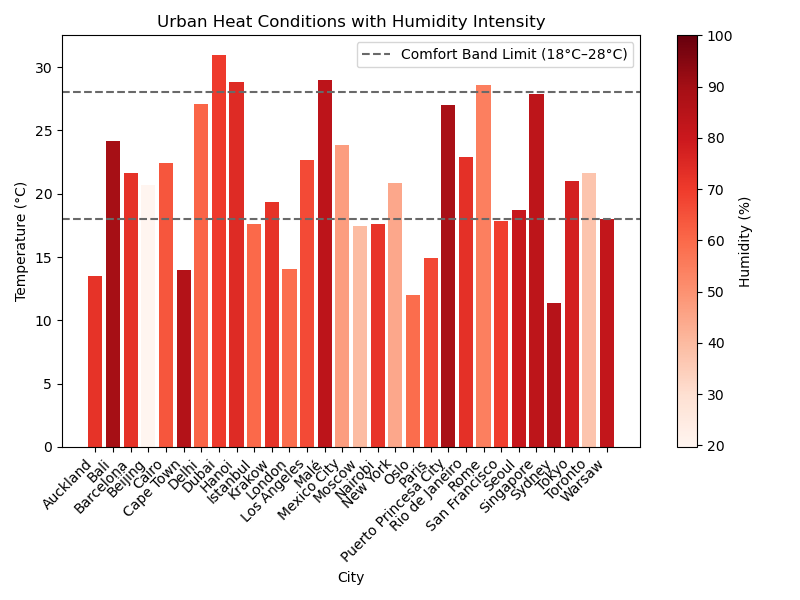

In [43]:
# Define simplified discomfort tagging function
def classify_discomfort(row):
    severe_conditions = ["Rain", "Thunderstorm", "Snow"]
    if row["condition_main"] in severe_conditions:
        return "Severe Weather"
    elif row["temperature"] > 28:
        return "Hot"
    elif row["temperature"] < 18:
        return "Cold"
    elif 18 <= row["temperature"] <= 28 and row["humidity"] > 75:
        return "Humid"
    else:
        return "Comfortable"

# Apply flagging
agg_df["flag"] = agg_df.apply(classify_discomfort, axis=1)

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors
from io import BytesIO
import base64

# --- Create the bar chart image ---
# Normalize color scale for humidity
norm = mcolors.Normalize(vmin=agg_df["humidity"].min(), vmax=100)
colors = cm.Reds(norm(agg_df["humidity"]))

# Create figure
fig, ax = plt.subplots(figsize=(8, 6))
bars = ax.bar(agg_df["city"], agg_df["temperature"], color=colors)
ax.set_xlabel("City")
ax.set_ylabel("Temperature (°C)")
ax.set_title("Urban Heat Conditions with Humidity Intensity")
plt.xticks(rotation=45, ha='right')

# Comfort band lines
boundary_color = 'dimgray'
ax.axhline(y=28, color=boundary_color, linestyle='--', linewidth=1.5, label='Comfort Band Limit (18°C–28°C)')
ax.axhline(y=18, color=boundary_color, linestyle='--', linewidth=1.5)

# Humidity colorbar
sm = cm.ScalarMappable(cmap="Reds", norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax)
cbar.set_label("Humidity (%)")
ax.legend(loc="upper right")

# Convert chart to base64 image
buf = BytesIO()
plt.tight_layout()
plt.savefig(buf, format='png')
plt.close(fig)
buf.seek(0)
img_base64 = base64.b64encode(buf.read()).decode('utf-8')

# --- Prepare Discomfort and Severe Weather Tables ---
# Filter flags
grouped = agg_df[agg_df["flag"].isin(["Hot", "Cold", "Humid"])].groupby("flag")["city"].apply(list)
flags = ["Hot", "Cold", "Humid"]
city_lists = {flag: grouped.get(flag, []) for flag in flags}
max_len = max(len(lst) for lst in city_lists.values())
for flag in flags:
    city_lists[flag] += [""] * (max_len - len(city_lists[flag]))
discomfort_df = pd.DataFrame(city_lists)

# Prepare severe table
severe_df = agg_df[agg_df["flag"].isin(["Rain", "Thunderstorm", "Snow"])][["city", "flag"]]

# --- Final Layout: Chart + 2 Tables ---
from IPython.display import HTML, display

html = f"""
<div style="display: flex; justify-content: flex-start; align-items: flex-start; gap: 30px; margin-top: 20px;">

  <!-- Bar Chart -->
  <div style="flex: 1; min-width: 550px;">
    <img src="data:image/png;base64,{img_base64}" style="width: 100%; height: auto; border: 1px solid #ccc; padding: 6px;">
  </div>

  <!-- Tables Column -->
  <div style="flex: 1.1; display: flex; flex-direction: column; gap: 20px; align-items: flex-start;">

    <!-- Discomfort Tags Table -->
    <div style="border: 2px solid #d6a300; background-color: #fffbe6; padding: 10px 14px; border-radius: 8px; width: 100%; max-width: 400px;">
      <h3 style="font-size: 16px; color: #b58900; text-align: center; margin-bottom: 4px;">
        🌡️ <span style='font-weight:700;'>Discomfort Tags by City</span>
      </h3>
      <div style="font-size: 13px;">
        {discomfort_df.style
          .hide(axis='index')
          .set_table_attributes('style="width:100%; font-size:13px;"')
          .set_table_styles([
            {'selector': 'th', 'props': [('font-weight', 'bold'), ('background-color', '#ffe680')]}
          ]).to_html()}
      </div>
    </div>

    <!-- Severe Weather Table -->
    <div style="border: 2px solid #a33; background-color: #fff5f5; padding: 10px 14px; border-radius: 8px; width: 100%; max-width: 400px;">
      <h3 style="font-size: 16px; color: #a33; text-align: center; margin-bottom: 4px;">
        ⛈️ <span style='font-weight:700;'>Severe Weather Alerts</span>
      </h3>
      <div style="font-size: 13px;">
        {severe_df.style
          .hide(axis='index')
          .set_table_attributes('style="width:100%; font-size:13px;"')
          .set_table_styles([
            {'selector': 'th', 'props': [('font-weight', 'bold'), ('background-color', '#ffcccc')]}
          ]).to_html()}
      </div>
    </div>

  </div>
</div>
"""
display(HTML(html))

**Sample insights from the result:**

1. Hot Conditions.*Cairo*, *Delhi*, *Dubai*, *Hanoi*, and *Singapore* exhibit high temperatures that may deter mid-day exploration.  
*Suggested actions:*
   - Promote hydration-focused products, hats, UV-protective clothing through retail partners.
   - Collaborate with hotels and cafes on indoor afternoon promotions (e.g., shaded patios, A/C lounges).
   - Encourage tour operators to shift to early-morning or evening time slots.

2. Cold Conditions. *Auckland*, *Cape Town*, *New York*, *Oslo*, *San Francisco*, *Seoul*, *Sydney*, *Tokyo*, *Toronto* show lower-than-comfort temperatures.  
*Suggested actions:*
   - Cross-promote with museums, theaters, and culinary indoor venues.
   - Partner with local businesses for warm beverage promotions or wellness/spa packages.

3. High Humidity. *Bali* and *Puerto Princesa City* are flagged for humidity discomfort, despite moderate temperatures.  
*Suggested actions:*
   - Partner with travel gear outlets to offer sweat-wicking apparel, portable fans, or cooling towels.
   - Offer discounts on indoor attractions (e.g., aquariums, malls, covered markets).

**Cities with Severe Weather Alerts**
*Maldives* is currently experiencing thunderstorms, and *Mexico City* is under a rain alert.  
  *Suggested actions:*
   - Suspend or postpone all outdoor excursions and water-based activities until local conditions stabilize.
   - Issue safety notifications to all travelers and staff in affected areas, emphasizing indoor shelter and weather monitoring.
   - Reassign guides or customer service staff to assist with last-minute rescheduling and cancellations.
   - For guests already booked on outdoor tours, offer alternatives such as:
     - Cultural or culinary indoor experiences
     - Access to indoor hotel amenities (lounges, fitness centers)
     - Movie or reading lounges for downtime


---

## 📚 Historical Weather Data Exploration (Supporting RTA Strategy & Forecasting)

While earlier sections focused on real-time weather streaming and decision-making, this section explores historical data to provide context and intelligence that enhance our RTA system.

This supports:
- Fine-tuning of real-time alert thresholds and comfort models
- Identification of long-term trends across cities and conditions
- Development of predictive models for weather-driven recommendations

In future extensions, this historical data can also be used to:
- Train machine learning models for short-term weather forecasting
- Simulate and test real-time alert logic under past conditions
- Personalize recommendations based on seasonal patterns or traveler profiles

Although this section uses batch analytics, it plays a strategic role in making our real-time system more intelligent, adaptive, and anticipatory.




To ensure the clarity and depth of insights in this section, we intentionally used a *smaller subset of cities* from the overall real-time dataset.

This subset was selected to:
- Represent diverse geographic regions and climate types
- Allow for more focused analysis of weather stability, volatility, and suitability
- Keep visualizations interpretable and meaningful without overwhelming the viewer

The goal is to extract strategic insights that can *inform real-time thresholds, model development, and destination planning* — while maintaining readability and analytical precision.

> In future versions, this analysis can be scaled to include the full city set as needed.

---



In [2]:
import pandas as pd
def load_and_clean_data():

    df = pd.read_csv("weather_data.csv")

    # Convert data types
    df['temperature'] = pd.to_numeric(df['temperature'])
    df['humidity'] = pd.to_numeric(df['humidity'])
    df['wind_speed'] = pd.to_numeric(df['wind_speed'])
    df['visibility'] = pd.to_numeric(df['visibility'])

    # Handle timestamp
    df['timestamp_readable'] = pd.to_datetime(df['timestamp_readable'])
    df['hour'] = df['timestamp_readable'].dt.hour

    # Create travel score
    def travel_score(row):
        score = 0
        # Temperature score
        if 15 <= row['temperature'] <= 25:
            score += 3
        elif 10 <= row['temperature'] <= 30:
            score += 2
        else:
            score += 1

        # Weather condition score
        if row['condition_main'] == 'Clear':
            score += 2
        elif row['condition_main'] == 'Clouds':
            score += 1

        return score

    df['travel_score'] = df.apply(travel_score, axis=1)
    df = df.drop_duplicates()
    df = df.dropna()

    return df

# Read and clean data
df_cleaned = load_and_clean_data()

### Chart 1: Multi-dimensional Radar Chart for City Weather Comparison
This radar chart provides a comprehensive view of each city's weather performance across multiple dimensions including temperature, humidity, wind speed, and visibility. Travel companies can use this visualization to quickly identify cities that excel across various weather metrics, making it easier to recommend optimal destinations for different types of activities. The larger the area covered by a city's polygon, the better its overall weather conditions for tourism and outdoor activities.

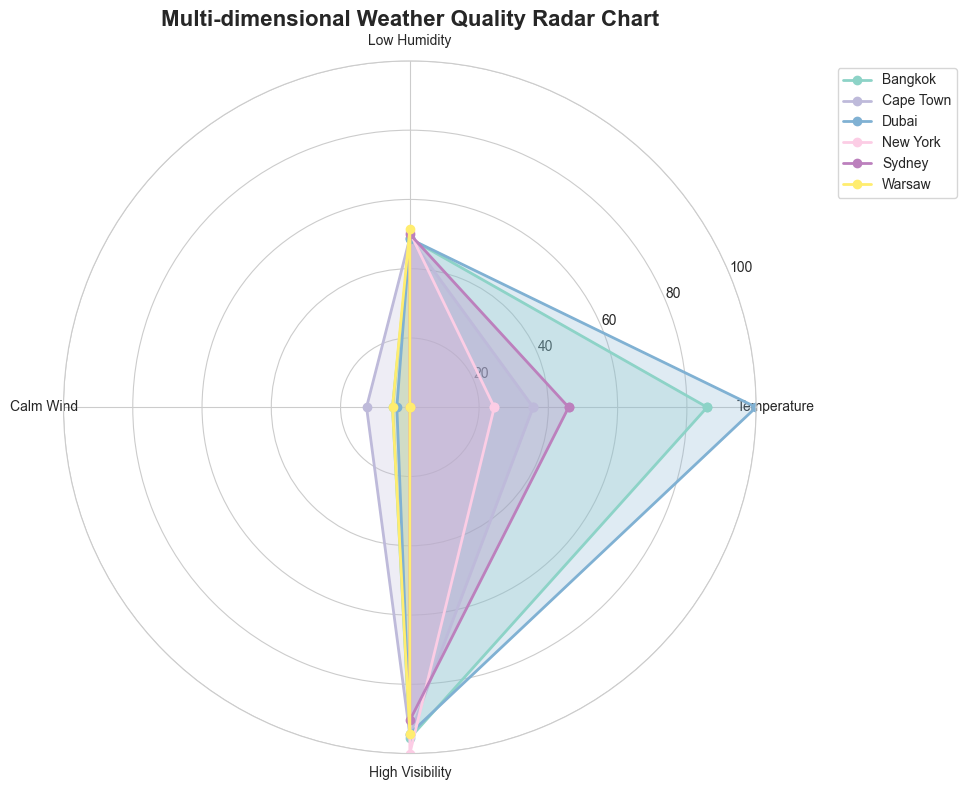

In [45]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from math import pi

# Calculate comprehensive weather metrics for each city using pandas
city_metrics = df_cleaned.groupby("city").agg({
   "temperature": "mean",
   "humidity": "mean",
   "wind_speed": "mean",
   "visibility": "mean"
}).round(1)

# Reset index to make city a column
city_metrics = city_metrics.reset_index()
city_metrics.columns = ["city", "avg_temp", "avg_humidity", "avg_wind", "avg_visibility"]

# Normalize data to 0-100 scale for radar chart
city_metrics['temp_score'] = ((city_metrics['avg_temp'] - city_metrics['avg_temp'].min()) /
                            (city_metrics['avg_temp'].max() - city_metrics['avg_temp'].min())) * 100
city_metrics['humidity_score'] = 100 - ((city_metrics['avg_humidity'] - 20) / 80) * 100  # Lower humidity = better
city_metrics['wind_score'] = 100 - ((city_metrics['avg_wind'] / city_metrics['avg_wind'].max()) * 100)  # Lower wind = better
city_metrics['visibility_score'] = (city_metrics['avg_visibility'] / city_metrics['avg_visibility'].max()) * 100

# Create radar chart
categories = ['Temperature', 'Low Humidity', 'Calm Wind', 'High Visibility']
fig, ax = plt.subplots(figsize=(10, 8), subplot_kw=dict(projection='polar'))

angles = [n / float(len(categories)) * 2 * pi for n in range(len(categories))]
angles += angles[:1]

colors = plt.cm.Set3(np.linspace(0, 1, len(city_metrics)))

for idx, (_, city_data) in enumerate(city_metrics.iterrows()):
   values = [city_data['temp_score'], city_data['humidity_score'],
             city_data['wind_score'], city_data['visibility_score']]
   values += values[:1]

   ax.plot(angles, values, 'o-', linewidth=2, label=city_data['city'], color=colors[idx])
   ax.fill(angles, values, alpha=0.25, color=colors[idx])

ax.set_xticks(angles[:-1])
ax.set_xticklabels(categories)
ax.set_ylim(0, 100)
plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.0))
plt.title("Multi-dimensional Weather Quality Radar Chart", size=16, fontweight='bold')
plt.tight_layout()
plt.show()

### Chart 2: Time Series Weather Trends and Seasonal Patterns
This comprehensive time series visualization tracks temperature and humidity patterns over time for all monitored cities. The dual-axis design allows tourism operators to identify seasonal patterns and weather stability, which is crucial for planning tour schedules and managing customer expectations. Cities with stable weather patterns are ideal for consistent tourism operations, while those with high variability might require flexible itinerary planning.

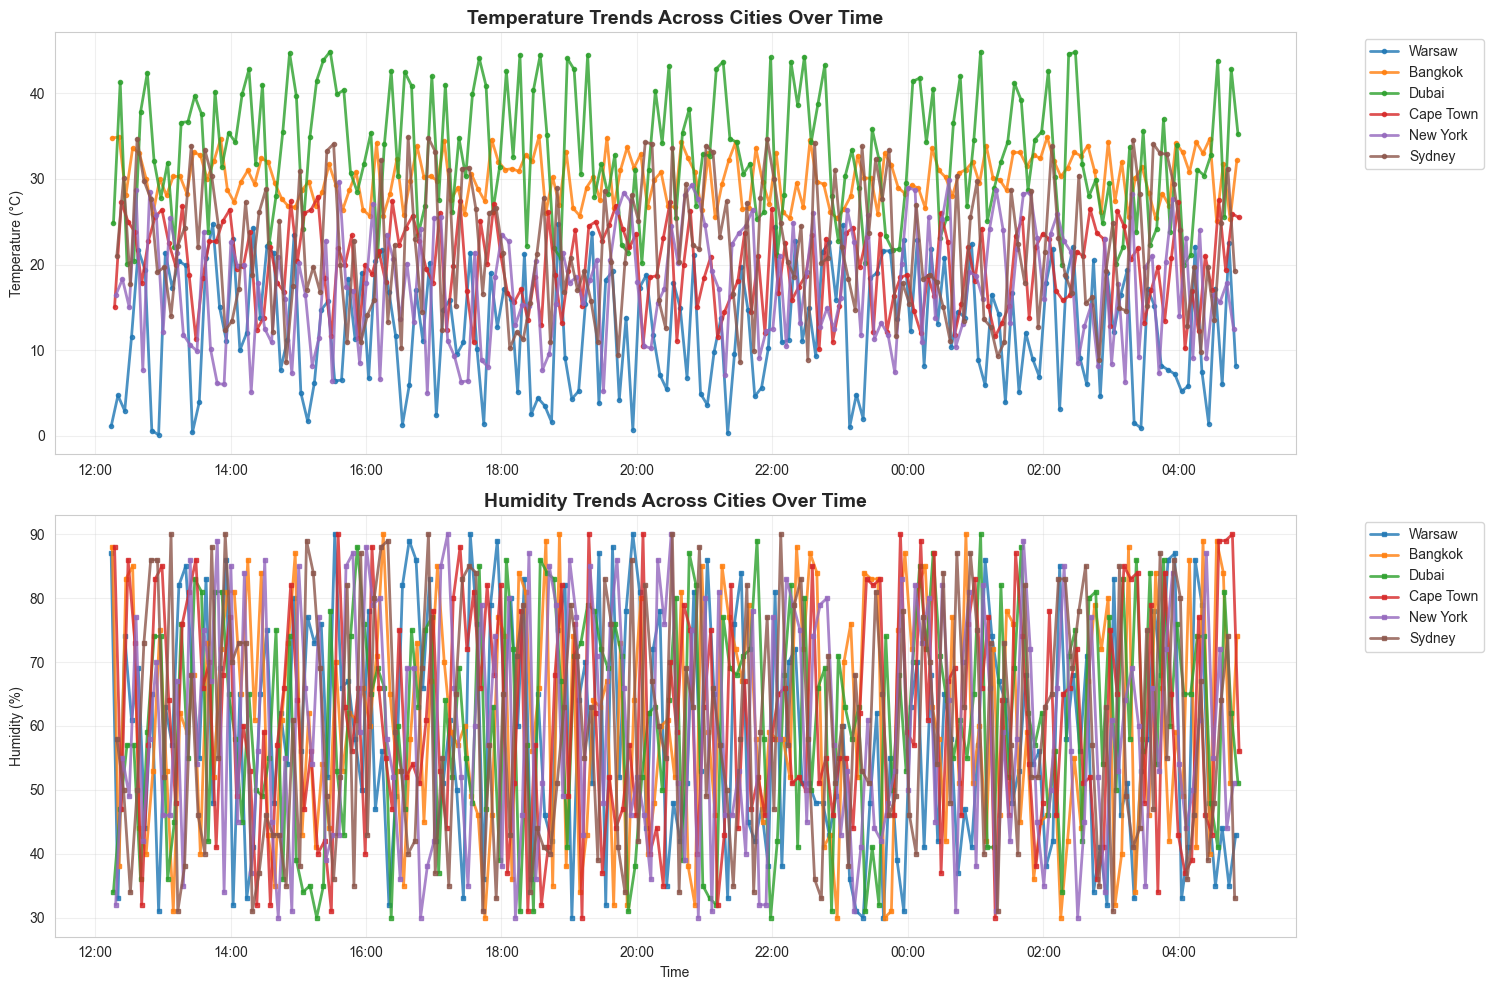

In [47]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime

# Convert timestamp to proper datetime format and add time features using pandas
df_time = df_cleaned.copy()
df_time['datetime'] = pd.to_datetime(df_time['timestamp_readable'])
df_time['hour_of_day'] = df_time['datetime'].dt.hour
df_time['day_of_week'] = df_time['datetime'].dt.dayofweek

# Prepare time series data
time_data = df_time[["city", "datetime", "temperature", "humidity", "hour_of_day"]].copy()
time_data = time_data.sort_values('datetime')

# Create subplots for temperature and humidity trends
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10))

# Temperature trends
for city in time_data['city'].unique():
   city_data = time_data[time_data['city'] == city]
   ax1.plot(city_data['datetime'], city_data['temperature'],
            marker='o', markersize=3, linewidth=2, label=city, alpha=0.8)

ax1.set_title('Temperature Trends Across Cities Over Time', fontsize=14, fontweight='bold')
ax1.set_ylabel('Temperature (°C)')
ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax1.grid(True, alpha=0.3)
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))

# Humidity trends
for city in time_data['city'].unique():
   city_data = time_data[time_data['city'] == city]
   ax2.plot(city_data['datetime'], city_data['humidity'],
            marker='s', markersize=3, linewidth=2, label=city, alpha=0.8)

ax2.set_title('Humidity Trends Across Cities Over Time', fontsize=14, fontweight='bold')
ax2.set_ylabel('Humidity (%)')
ax2.set_xlabel('Time')
ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax2.grid(True, alpha=0.3)
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))

plt.tight_layout()
plt.show()

### Chart 3: Dynamic Weather Condition Heatmap by Hour and City
This heatmap visualization reveals the optimal timing for travel activities across different cities throughout the day. By showing the distribution of favorable weather conditions (clear skies, moderate temperatures) by hour, tourism companies can optimize tour scheduling and provide data-driven recommendations to travelers. Dark blue areas indicate peak travel conditions, while lighter areas suggest times when indoor activities might be preferable.

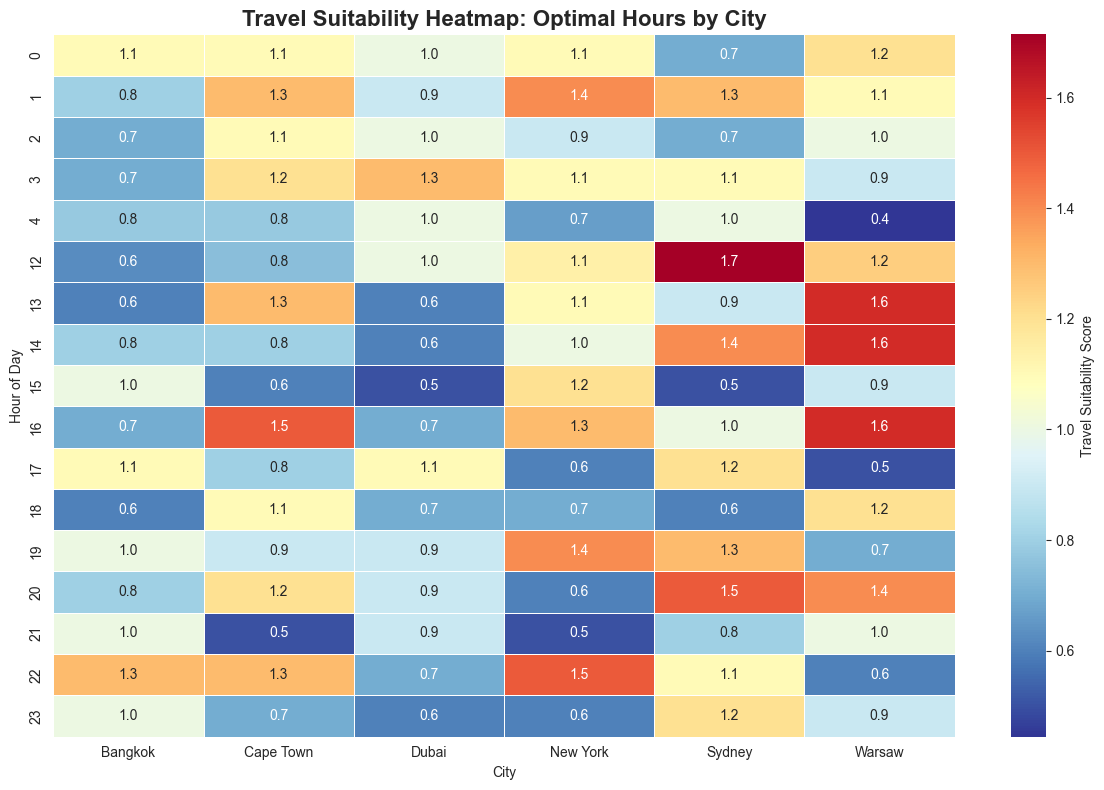

In [48]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Create travel suitability score and extract hour
df_scored = df_cleaned.copy()

# Create travel score using pandas conditions
def calculate_travel_score(row):
   if (15 <= row['temperature'] <= 25) and (row['condition_main'] == "Clear"):
       return 3
   elif (10 <= row['temperature'] <= 30) and (row['condition_main'] in ["Clear", "Clouds"]):
       return 2
   elif row['condition_main'] in ["Rain", "Thunderstorm"]:
       return 0
   else:
       return 1

df_scored['travel_score'] = df_scored.apply(calculate_travel_score, axis=1)
df_scored['hour'] = pd.to_datetime(df_scored['timestamp_readable']).dt.hour

# Aggregate travel scores by hour and city
heatmap_data = df_scored.groupby(['hour', 'city'])['travel_score'].mean().reset_index()
heatmap_data.columns = ['hour', 'city', 'avg_travel_score']

# Pivot for heatmap
heatmap_pivot = heatmap_data.pivot(index='hour', columns='city', values='avg_travel_score')

# Create enhanced heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_pivot, annot=True, fmt='.1f', cmap='RdYlBu_r',
           cbar_kws={'label': 'Travel Suitability Score'},
           linewidths=0.5, square=False)
plt.title('Travel Suitability Heatmap: Optimal Hours by City',
         fontsize=16, fontweight='bold')
plt.ylabel('Hour of Day')
plt.xlabel('City')
plt.tight_layout()
plt.show()

### Chart 4: Weather Volatility and Risk Assessment Scatter Plot
This scatter plot analysis helps identify cities with consistent versus unpredictable weather patterns by plotting temperature variability against humidity fluctuations. Cities positioned in the lower-left quadrant offer the most stable conditions, ideal for reliable tour operations. Those in the upper-right quadrant require more flexible planning due to high weather variability, but may offer unique seasonal experiences for adventurous travelers.

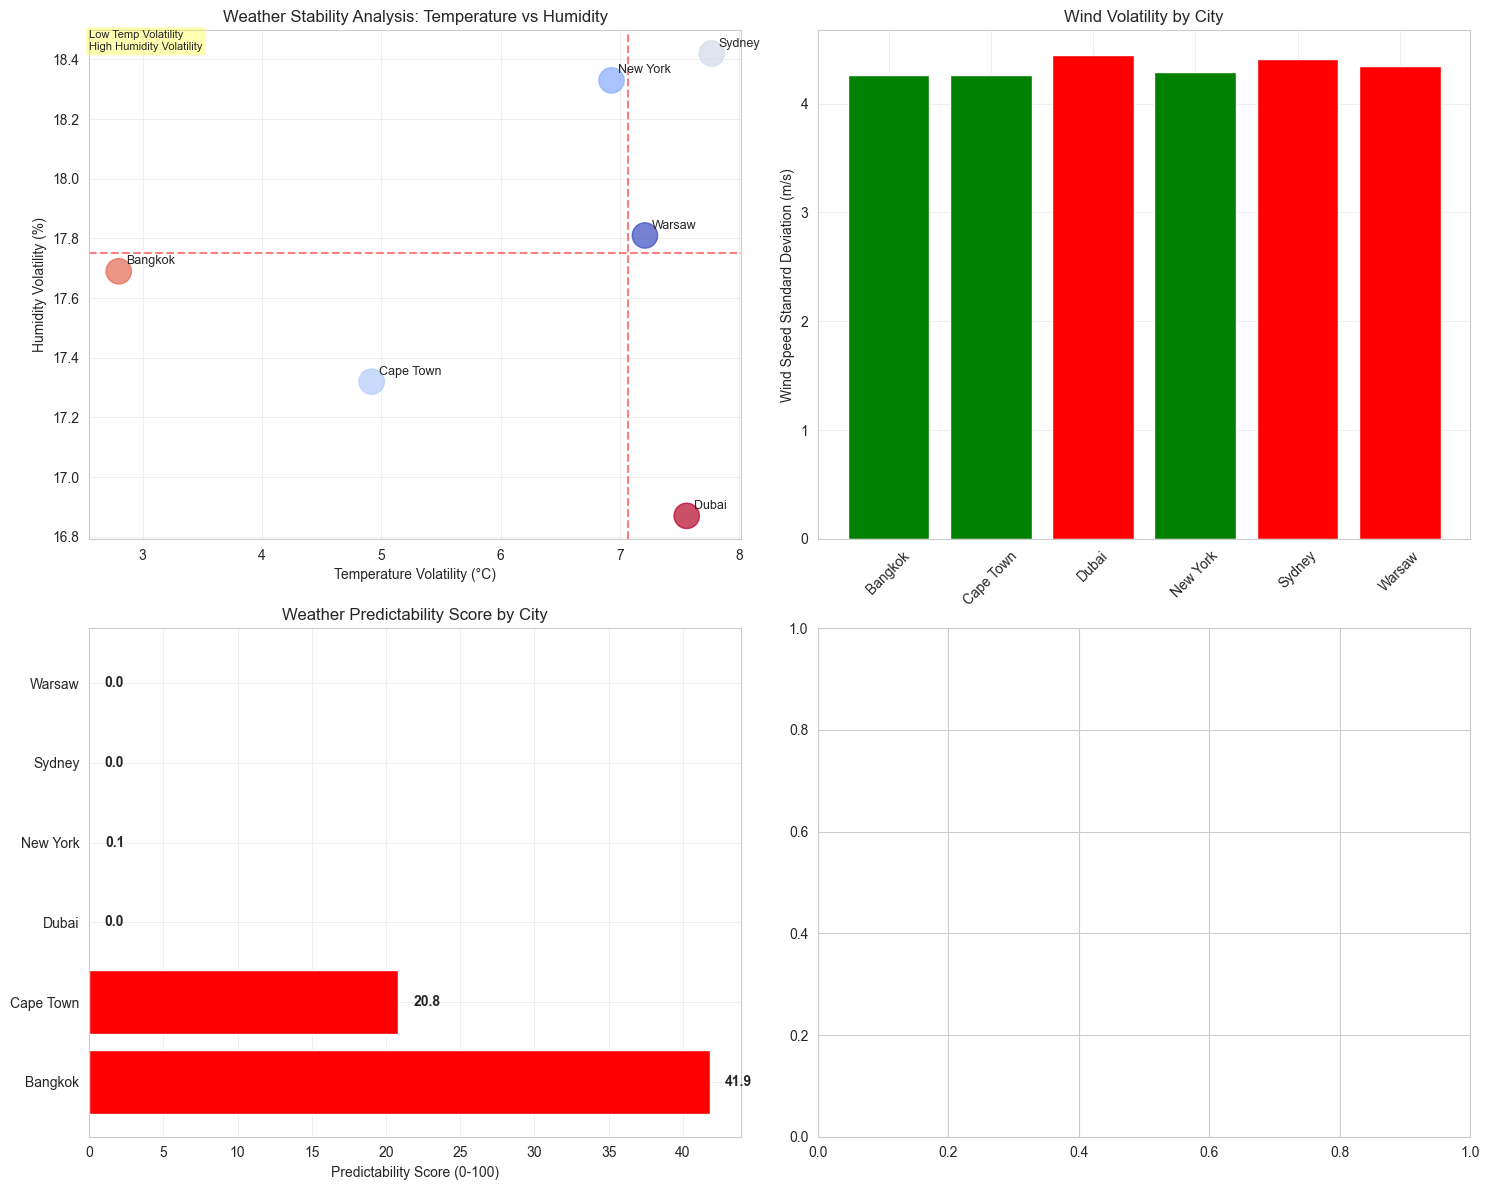

In [49]:
# Calculate weather volatility metrics using pandas
volatility_metrics = df_cleaned.groupby("city").agg({
   "temperature": ["mean", "std"],
   "humidity": ["mean", "std"],
   "wind_speed": ["mean", "std"],
   "city": "count"
}).round(2)

# Flatten column names
volatility_metrics.columns = ['avg_temp', 'temp_volatility', 'avg_humidity', 'humidity_volatility',
                            'avg_wind', 'wind_volatility', 'data_points']
volatility_metrics = volatility_metrics.reset_index()

# Create scatter plot
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))

# Temperature vs Humidity volatility
scatter1 = ax1.scatter(volatility_metrics['temp_volatility'],
                     volatility_metrics['humidity_volatility'],
                     s=volatility_metrics['data_points']*2,
                     alpha=0.7, c=volatility_metrics['avg_temp'],
                     cmap='coolwarm')
for i, city in enumerate(volatility_metrics['city']):
   ax1.annotate(city, (volatility_metrics['temp_volatility'].iloc[i],
                      volatility_metrics['humidity_volatility'].iloc[i]),
               xytext=(5, 5), textcoords='offset points', fontsize=9)
ax1.set_xlabel('Temperature Volatility (°C)')
ax1.set_ylabel('Humidity Volatility (%)')
ax1.set_title('Weather Stability Analysis: Temperature vs Humidity')
ax1.grid(True, alpha=0.3)

# Risk assessment quadrants
ax1.axhline(y=volatility_metrics['humidity_volatility'].median(), color='red', linestyle='--', alpha=0.5)
ax1.axvline(x=volatility_metrics['temp_volatility'].median(), color='red', linestyle='--', alpha=0.5)
ax1.text(ax1.get_xlim()[0], ax1.get_ylim()[1], 'Low Temp Volatility\nHigh Humidity Volatility',
        fontsize=8, ha='left', va='top', bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.3))

# Wind volatility analysis
ax2.bar(volatility_metrics['city'], volatility_metrics['wind_volatility'],
       color=['red' if x > volatility_metrics['wind_volatility'].mean() else 'green'
              for x in volatility_metrics['wind_volatility']])
ax2.set_title('Wind Volatility by City')
ax2.set_ylabel('Wind Speed Standard Deviation (m/s)')
ax2.tick_params(axis='x', rotation=45)
ax2.grid(True, alpha=0.3)

# Overall weather predictability score
volatility_metrics['predictability_score'] = (
   100 - (volatility_metrics['temp_volatility'] * 10 +
          volatility_metrics['humidity_volatility'] * 0.5 +
          volatility_metrics['wind_volatility'] * 5)
).clip(0, 100)

ax3.barh(volatility_metrics['city'], volatility_metrics['predictability_score'],
        color=['darkgreen' if x > 70 else 'orange' if x > 50 else 'red'
               for x in volatility_metrics['predictability_score']])
ax3.set_title('Weather Predictability Score by City')
ax3.set_xlabel('Predictability Score (0-100)')
ax3.grid(True, alpha=0.3)

# Add value labels on bars
for i, v in enumerate(volatility_metrics['predictability_score']):
   ax3.text(v + 1, i, f'{v:.1f}', va='center', fontweight='bold')

plt.tight_layout()
plt.show()


### Chart 5: Interactive Business Intelligence Dashboard for Tourism Marketing
This comprehensive dashboard combines multiple visualization techniques to provide actionable business intelligence for tourism marketing strategies. The combination of geographical mapping, promotional opportunity identification, and seasonal trend analysis enables marketing teams to make data-driven decisions about campaign timing, product promotions, and target market selection based on real-time weather patterns.

Marketing Intelligence Data:
        city  avg_temp  avg_humidity  total_observations  clear_weather_ratio  \
0    Bangkok      30.1          61.0                 167                 0.16   
1  Cape Town      19.8          60.9                 167                 0.14   
2      Dubai      33.0          61.1                 167                 0.21   
3   New York      17.5          59.6                 166                 0.14   
4     Sydney      21.9          60.0                 166                 0.18   
5     Warsaw      12.5          58.9                 167                 0.16   

                                  promotion_strategy  
0  Flexible Promotions: All-weather gear, indoor/...  
1  Flexible Promotions: All-weather gear, indoor/...  
2  Flexible Promotions: All-weather gear, indoor/...  
3  Flexible Promotions: All-weather gear, indoor/...  
4  Flexible Promotions: All-weather gear, indoor/...  
5  Winter Promotions: Warm clothing, hot beverage...  


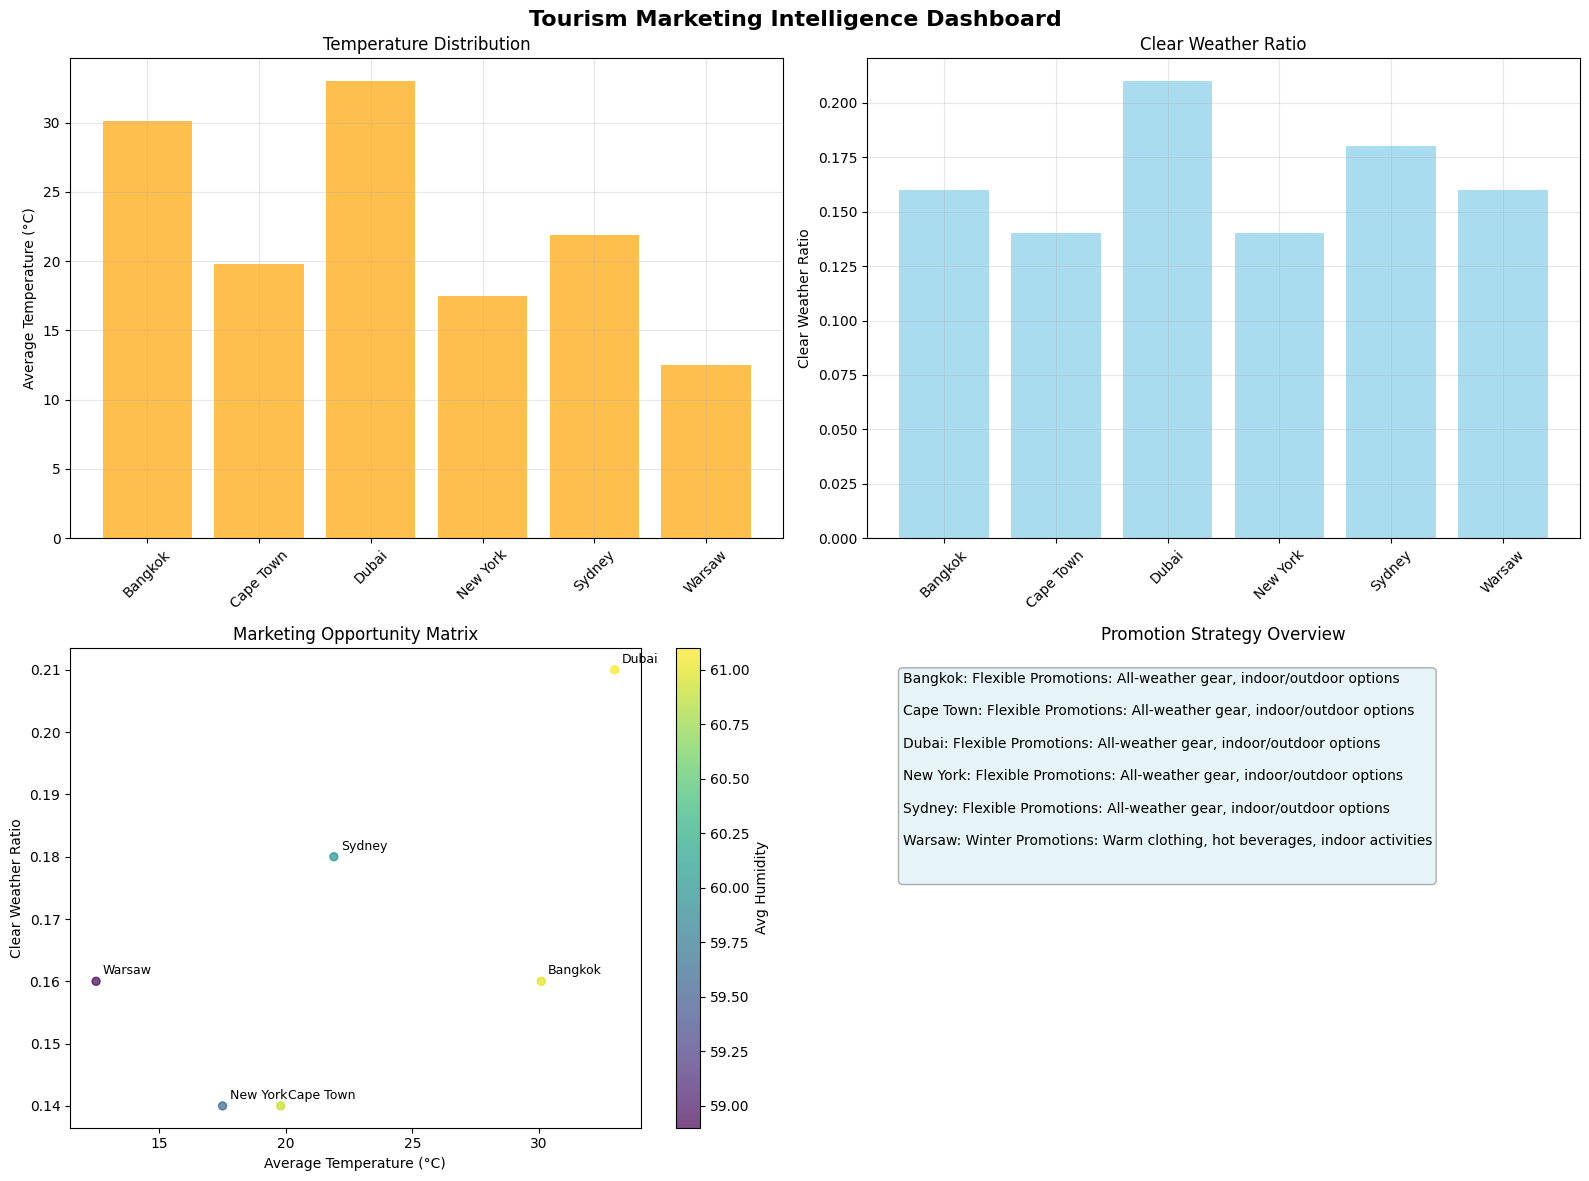

In [55]:
# Prepare marketing intelligence data using pandas
marketing_data = df_cleaned.groupby("city").agg({
    "temperature": "mean",
    "humidity": "mean",
    "city": "count"
}).round(1)

marketing_data.columns = ['avg_temp', 'avg_humidity', 'total_observations']
marketing_data = marketing_data.reset_index()

# Calculate clear weather ratio
clear_weather = df_cleaned[df_cleaned['condition_main'] == 'Clear'].groupby('city').size()
total_weather = df_cleaned.groupby('city').size()
clear_weather_ratio = (clear_weather / total_weather).fillna(0).round(2)
marketing_data['clear_weather_ratio'] = marketing_data['city'].map(clear_weather_ratio)

# Add promotional recommendations
def get_promotion_strategy(row):
    if row['avg_temp'] > 28 and row['clear_weather_ratio'] > 0.6:
        return "Summer Promotions: Cooling products, beach gear, ice cream"
    elif row['avg_temp'] < 15:
        return "Winter Promotions: Warm clothing, hot beverages, indoor activities"
    elif row['avg_humidity'] > 80:
        return "Humid Weather Promotions: Dehumidifiers, light clothing, refreshing drinks"
    elif row['clear_weather_ratio'] > 0.7:
        return "Outdoor Promotions: Hiking gear, sunglasses, outdoor tours"
    else:
        return "Flexible Promotions: All-weather gear, indoor/outdoor options"

marketing_data['promotion_strategy'] = marketing_data.apply(get_promotion_strategy, axis=1)

# Display marketing data
print("Marketing Intelligence Data:")
print(marketing_data)

# Create matplotlib dashboard
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

# Temperature distribution
ax1.bar(marketing_data['city'], marketing_data['avg_temp'], color='orange', alpha=0.7)
ax1.set_title('Temperature Distribution')
ax1.set_ylabel('Average Temperature (°C)')
ax1.tick_params(axis='x', rotation=45)
ax1.grid(True, alpha=0.3)

# Clear weather ratio
ax2.bar(marketing_data['city'], marketing_data['clear_weather_ratio'], color='skyblue', alpha=0.7)
ax2.set_title('Clear Weather Ratio')
ax2.set_ylabel('Clear Weather Ratio')
ax2.tick_params(axis='x', rotation=45)
ax2.grid(True, alpha=0.3)

# Marketing opportunity matrix
scatter = ax3.scatter(marketing_data['avg_temp'], marketing_data['clear_weather_ratio'],
                     s=marketing_data['total_observations']/5,
                     c=marketing_data['avg_humidity'], cmap='viridis', alpha=0.7)  # 改为小写 viridis
for i, city in enumerate(marketing_data['city']):
    ax3.annotate(city, (marketing_data['avg_temp'].iloc[i], marketing_data['clear_weather_ratio'].iloc[i]),
                xytext=(5, 5), textcoords='offset points', fontsize=9)
ax3.set_xlabel('Average Temperature (°C)')
ax3.set_ylabel('Clear Weather Ratio')
ax3.set_title('Marketing Opportunity Matrix')
plt.colorbar(scatter, ax=ax3, label='Avg Humidity')

# Promotion strategy text display
ax4.axis('off')
ax4.set_title('Promotion Strategy Overview')
strategy_text = ""
for i, row in marketing_data.iterrows():
    strategy_text += f"{row['city']}: {row['promotion_strategy']}\n\n"
ax4.text(0.05, 0.95, strategy_text, transform=ax4.transAxes, fontsize=10,
         verticalalignment='top', bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.3))

plt.suptitle("Tourism Marketing Intelligence Dashboard", fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

In a live deployment, these insights could trigger dynamic marketing content, pop-up offers, or destination promotions based on real-time matching conditions.

---

### Summary: How Historical Insights Power Real-Time Decisions

This section explored past weather patterns across selected cities to reveal consistent trends, suitability windows, and risk factors.  
While not streaming-based, these insights play a critical role in tuning and validating the real-time system — ensuring that live outputs are not only reactive, but also informed by broader patterns.

In future iterations, these models and trends may directly shape:
- Real-time alert logic
- Activity recommendation engines
- Weather-personalized marketing triggers

This historical layer closes the loop — turning past patterns into smarter, faster real-time decisions.
